# Twitter API v2

**Academic Research Access Overview**

->1 Environment per project

->10Million Tweets per month/project

### Academic Research Feature

**Tweets Lookup**
Retrieve detailed, up-to-date information about a specific Tweet, or Tweets.

GET /2/tweets/:id
Rate limit
300 requests / 15 mins
PER APP

900 requests / 15 mins
PER USER
Tweet cap
no

**Search Tweets**
**(recent search)**

GET /2/tweets/search/recent
Rate limit
180 requests / 15 mins
PER USER
450 requests / 15 mins
PER APP
Tweet cap
yes
Special attributes
10 default results per response
100 results per response
enhanced operators
1024 query length


**(FULL ARCHIVE SEARCH):**

GET /2/tweets/search/all
Rate limit
300 requests / 15 mins
PER APP
1 requests / second
PER USER
1 requests / second
PER APP
Tweet cap
yes
Special attributes
500 results per response
10 default results per response
enhanced operators
1024 query length


# Import Libraries

In [78]:
# For sending GET requests from the API
import requests
# For saving access tokens and for file management when creating and adding to the dataset
import os
# For dealing with json responses we receive from the API
import json
# For displaying the data after
import pandas as pd
# For saving the response data in CSV format
import csv
# For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata
#To add wait time between requests
import time

import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB

import tensorflow.compat.v2 as tf
import numpy as np 
import warnings
warnings.filterwarnings('ignore')
import re
import string

In [2]:
#Set environment variable 'TOKEN' to my twitter app bearer token

'''
What is a twitter Bearer Token?

A bearer token allows developers to have a more secure point of entry for using the Twitter APIs, 
and are one of the core features of OAuth 2.0
'''


#IMPORTANT: Keep TWITTER APP PROJECT, API key, API Secret Key and Bearer token
#secret(can be regenerated for project)
os.environ['TOKEN'] = 'AAAAAAAAAAAAAAAAAAAAACzPZgEAAAAAUbTj7vOIhhmxJddqJnYf18MWnrA%3DBoZHZgD03Q36JPKiCmPOwF4sZPPEqo7LurTKH0LiCPT3rTpnhZ'

In [3]:
'''
Utility function

auth() -> retrieve the twitter bearer token from env
'''
def auth():
    return os.getenv('TOKEN')

In [4]:
'''
Create twitter headers

define a function that will take our bearer token, pass it for authorization and return headers we will use to access the API.

'''

def create_headers(bearer_token):
    headers = {"Authorization": "Bearer {}".format(bearer_token)}
    return headers

In [6]:
'''
CREATE URL

Now that we can access the API, we will build the request for the endpoint we are going to use and the 
parameters we want to pass.


create_url() contains TWO pieces

(A) search_url:

Which is the link of the endpoint we want to access.
Twitter’s API has a lot of different endpoints

/search/all uses the full archive search endpoint(available only for academic research access)


(B) query_params:

The parameters that the endpoint offers and we can use to customize the request we want to send.
Each endpoint has different parameters that we can pass to it

First four parameters are the ones we are controlling

'query':        keyword,
'start_time':   start_date,
'end_time':     end_date,
'max_results':  max_results,

next 4 parameters are basically us instructing the endpoint to return more information that is optional 
that it won’t return by default.

next_token parameter is used to get the next page of results

The query parameter is where you put the keyword(s) you want to search for.

Queries can be as simple as searching for tweets containing the word “xbox” or as complex as “(xbox europe) OR (xbox usa)” 
which will return tweets that contain the words xbox AND europe or xbox AND usa.

TWITTER DEV PLATFORM DOCUMENTATION(BUILDING QUERIES FOR SEARCH TWEETS)
https://developer.twitter.com/en/docs/twitter-api/tweets/search/integrate/build-a-query

Results volume: max_results
The number of search results returned by a request is currently limited between 10 and 500 results.

'''

def create_url(keyword, start_date, end_date, max_results = 500):
    
    search_url = "https://api.twitter.com/2/tweets/search/all" #Change to the endpoint you want to collect data from

    #change params based on the endpoint you are using
    query_params = {'query': keyword,
                    'start_time': start_date,
                    'end_time': end_date,
                    'max_results': max_results,
                    'expansions': 'author_id,in_reply_to_user_id,geo.place_id',
                    'tweet.fields': 'id,text,author_id,in_reply_to_user_id,geo,conversation_id,created_at,lang,public_metrics,referenced_tweets,reply_settings,source',
                    'user.fields': 'id,name,username,created_at,description,public_metrics,verified',
                    'place.fields': 'full_name,id,country,country_code,geo,name,place_type',
                    'next_token': {}}
    return (search_url, query_params)

In [7]:
#Connecting to twitter endpoint

#RESPONSE CODE 200: SUCCESS

def connect_to_endpoint(url, headers, params, next_token = None):
    params['next_token'] = next_token   #params object received from create_url function
    response = requests.request("GET", url, headers = headers, params = params)
    print("Endpoint Response Code: " + str(response.status_code))
    if response.status_code != 200:
        raise Exception(response.status_code, response.text)
    return response.json()

In [11]:
'''

#quick sample 
->bearer_token and headers from the API.
->We will look for tweets in English that contain the hastag “#antivaxxers” and "vaccination".
We will look for tweets between the 1st and the 31st of March, 2021.(covid relevant)
We want only a maximum of 500 tweets returned.

'''

#Inputs for the request
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "#antivaxxers vaccination"
start_time = "2021-03-01T00:00:00.000Z"
end_time = "2021-03-31T00:00:00.000Z"
max_results = 500

In [12]:
'''
create the URL and get response from twitter API

->response from twitter API is returned in JSON format

if returned response request was successful(response code 200)

'''

url = create_url(keyword, start_time,end_time, max_results)
json_response = connect_to_endpoint(url[0], headers, url[1])

Endpoint Response Code: 200


In [13]:
#Print response in a legible format using JSON library

print(json.dumps(json_response, indent=4, sort_keys=True))

{
    "data": [
        {
            "author_id": "732778398",
            "conversation_id": "1377034948511735822",
            "created_at": "2021-03-30T23:08:10.000Z",
            "id": "1377034948511735822",
            "lang": "en",
            "public_metrics": {
                "like_count": 0,
                "quote_count": 0,
                "reply_count": 0,
                "retweet_count": 1
            },
            "referenced_tweets": [
                {
                    "id": "1377034881042165762",
                    "type": "retweeted"
                }
            ],
            "reply_settings": "everyone",
            "source": "Twitter Web App",
            "text": "RT @EvanSteeg1: It's a race between vaccination, public health professionals &amp; good citizens on the one side vs. #antivaxxers #antimaskers\u2026"
        },
        {
            "author_id": "732778398",
            "conversation_id": "1377034881042165762",
            "created_at": "2021-03-3

## Convert JSON response to CSV file

In [19]:
#create a CSV file with column headers

# Create CSV file named: 'twitter_data.csv' with utf-8 encoding
csvFile = open("twitter_data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

In [20]:
'''
append_to_csv() function, 
will input the response and desired filename into, and the function will append all the data we collected to the CSV file.
'''

def append_to_csv(json_response, fileName):

    #A counter variable
    counter = 0

    #Open OR create the target CSV file
    csvFile = open(fileName, "a", newline="", encoding='utf-8')
    csvWriter = csv.writer(csvFile)

    #Loop through each tweet
    for tweet in json_response['data']:
        
        # We will create a variable for each since some of the keys might not exist for some tweets
        # So we will account for that

        # 1. Author ID
        author_id = tweet['author_id']

        # 2. Time created
        created_at = dateutil.parser.parse(tweet['created_at'])

        # 3. Geolocation
        if ('geo' in tweet):   
            geo = tweet['geo']['place_id']
        else:
            geo = " "

        # 4. Tweet ID
        tweet_id = tweet['id']

        # 5. Language
        lang = tweet['lang']

        # 6. Tweet metrics
        retweet_count = tweet['public_metrics']['retweet_count']
        reply_count = tweet['public_metrics']['reply_count']
        like_count = tweet['public_metrics']['like_count']
        quote_count = tweet['public_metrics']['quote_count']

        # 7. source
        source = tweet['source']

        # 8. Tweet text
        text = tweet['text']
        
        # Assemble all data in a list
        res = [author_id, created_at, geo, tweet_id, lang, like_count, quote_count, reply_count, retweet_count, source, text]
        
        # Append the result to the CSV file
        csvWriter.writerow(res)
        counter += 1

    # When done, close the CSV file
    csvFile.close()

    # Print the number of tweets for this iteration
    print("# of Tweets added from this response: ", counter) 

In [21]:
#RUN append_to_csv function passing JSON response into a file called twitter_data.csv

append_to_csv(json_response, "twitter_data.csv")

#only 140 tweets returned for query

# of Tweets added from this response:  140


In [22]:
#Using pandas, stored in twitter_data.csv in a pandas dataframe object

data = pd.read_csv('twitter_data.csv')

#print first 5 rows of dataframe

data.head()

,author id,created_at,geo,id,lang,like_count,quote_count,reply_count,retweet_count,source,tweet
0,732778398,2021-03-30 23:08:10+00:00,,1377034948511735822,en,0,0,0,1,Twitter Web App,RT @EvanSteeg1: It's a race between vaccinatio...
1,732778398,2021-03-30 23:07:54+00:00,,1377034881042165762,en,1,0,0,1,Twitter Web App,"It's a race between vaccination, public health..."
2,16271264,2021-03-30 16:11:22+00:00,,1376930057411686401,en,0,0,0,1,Twitter Web App,RT @realMaemoxie: @RepBoebert Proof of vaccina...
3,850867471150047232,2021-03-30 15:38:56+00:00,,1376921894063009793,en,6,0,0,1,Twitter Web App,@RepBoebert Proof of vaccination is an affront...
4,594709355,2021-03-30 10:52:47+00:00,,1376849882523316224,en,0,0,0,0,Twitter Web App,The merits and ills of this specific cohort of...


In [23]:
#Print shape of dataframe

data.shape

(140, 11)

In [24]:
#dataframe attribute technical information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   author id      140 non-null    int64 
 1   created_at     140 non-null    object
 2   geo            140 non-null    object
 3   id             140 non-null    int64 
 4   lang           140 non-null    object
 5   like_count     140 non-null    int64 
 6   quote_count    140 non-null    int64 
 7   reply_count    140 non-null    int64 
 8   retweet_count  140 non-null    int64 
 9   source         140 non-null    object
 10  tweet          140 non-null    object
dtypes: int64(6), object(5)
memory usage: 12.2+ KB


In [25]:
#dataframe columns
data.columns

Index(['author id', 'created_at', 'geo', 'id', 'lang', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'source', 'tweet'],
      dtype='object')

In [26]:
#DROP all columns except for 'tweet' column which is the tweet itself

data.drop(columns=['author id', 'created_at', 'geo', 'id', 'lang', 'like_count',
       'quote_count', 'reply_count', 'retweet_count', 'source'], axis=1, inplace=True)

In [27]:
data.head()

,tweet
0,RT @EvanSteeg1: It's a race between vaccinatio...
1,"It's a race between vaccination, public health..."
2,RT @realMaemoxie: @RepBoebert Proof of vaccina...
3,@RepBoebert Proof of vaccination is an affront...
4,The merits and ills of this specific cohort of...


In [29]:
#print the first tweet
data['tweet'][0]

"RT @EvanSteeg1: It's a race between vaccination, public health professionals &amp; good citizens on the one side vs. #antivaxxers #antimaskers…"

In [31]:
#change 'tweet' into 'text' header column
data.columns = ['text']

In [33]:
#convrting pandas object to a string type
data['text'] = data['text'].astype('str')

# Text Preprocessing

'''
The Preprocessing steps taken are:

**Lower Casing:** Each text is converted to lowercase.

**Removing URLs:** Links starting with "http" or "https" or "www" are replaced by "".

**Removing Usernames:** Replace @Usernames with word "". (eg: "@XYZ" to "")

**Removing Short Words:** Words with length less than 2 are removed.

**Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. (eg: "the", "he", "have")

**Lemmatizing:** Lemmatization is the process of converting a word to its base form. (e.g: “wolves” to “wolf”)
'''

In [34]:
#importing stopword from nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stopword = set(stopwords.words('english'))
print(stopword)

{"mustn't", "didn't", 'yourselves', 'himself', 'again', 'by', 'down', 'such', 'has', 'into', 'we', 'be', 'mightn', 'other', 'what', 'both', 'here', 'if', 'him', 'a', 'off', 'so', 'am', 'this', 'needn', 'were', "you've", 'aren', 'do', 'm', 'ma', 'there', 'after', 're', 'my', 'couldn', 'few', 'any', 'these', 'or', 'those', 'haven', 'will', 'same', "won't", 'than', "shouldn't", "weren't", 'on', 'above', 'only', 'in', 'not', 'whom', 'd', 'doesn', 'that', 'of', "hasn't", "you'll", "don't", 'me', "isn't", 'was', 'doing', 'for', 'wasn', 'how', 'y', 'weren', 'just', 'some', 'the', 'too', "hadn't", 'further', "mightn't", 'its', 'can', 'hasn', 'out', 'had', 'yourself', 'who', 'themselves', 'should', 'from', "that'll", 'our', 'ours', 'their', "it's", 't', 'nor', 'isn', 'does', 'she', "wasn't", "doesn't", 'ain', 'with', 'up', 'when', 'and', 'because', 'are', 'each', "should've", 'itself', 'your', "haven't", 'hadn', 'myself', 'between', 'shan', 'through', 'ourselves', 'at', 've', 'all', 'don', 'bef

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [35]:
'''
Punkt Sentence Tokenizer

This tokenizer divides a text into a list of sentences
by using an unsupervised algorithm to build a model for abbreviation
words, collocations, and words that start sentences.  It must be
trained on a large collection of plaintext in the target language
before it can be used.

WordNet is used for lemmatizing 
'''

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [36]:
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'

import re
import string

def process_tweets(tweet):
  # Lower Casing
    tweet = tweet.lower()
    tweet=tweet[1:]
    # Removing all URls 
    tweet = re.sub(urlPattern,'',tweet)
    # Removing all @username.
    tweet = re.sub(userPattern,'', tweet) 
    #Remove punctuations
    tweet = tweet.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    tokens = word_tokenize(tweet)
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]
    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [37]:
#apply process_tweets function to each entry in the text feature
data['processed_tweets'] = data['text'].apply(lambda x: process_tweets(x))

In [38]:
data.head()

,text,processed_tweets
0,RT @EvanSteeg1: It's a race between vaccinatio...,race vaccination public health professional am...
1,"It's a race between vaccination, public health...",t race vaccination public health professional ...
2,RT @realMaemoxie: @RepBoebert Proof of vaccina...,proof vaccination affront civil liberty 😱it ou...
3,@RepBoebert Proof of vaccination is an affront...,repboebert proof vaccination affront civil lib...
4,The merits and ills of this specific cohort of...,merit ill specific cohort covid19 vaccine asid...


In [39]:
#Perform sentiment analysis using vader(compound score) on each processed_tweets

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

def run_vader(text):
    return sid.polarity_scores(text)['compound']

data['vader_compound'] = data['processed_tweets'].apply(lambda x: run_vader(x))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Mia\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [40]:
data.head()

,text,processed_tweets,vader_compound
0,RT @EvanSteeg1: It's a race between vaccinatio...,race vaccination public health professional am...,0.4404
1,"It's a race between vaccination, public health...",t race vaccination public health professional ...,0.4404
2,RT @realMaemoxie: @RepBoebert Proof of vaccina...,proof vaccination affront civil liberty 😱it ou...,0.0516
3,@RepBoebert Proof of vaccination is an affront...,repboebert proof vaccination affront civil lib...,0.4019
4,The merits and ills of this specific cohort of...,merit ill specific cohort covid19 vaccine asid...,0.2500


In [41]:
#Descriptive stats on vader_compound score column

data['vader_compound'].describe()

count    140.000000
mean      -0.072292
std        0.446258
min       -0.848700
25%       -0.493100
50%        0.000000
75%        0.159300
max        0.916900
Name: vader_compound, dtype: float64

'\nSummary:\n\nmajority vader_compound scores are neutral\n\nmore fall towards the negative\n'

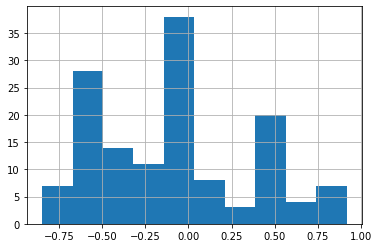

In [43]:
#create a histogram to see distribution of vader_compound intensity scores
data['vader_compound'].hist()

'''
Summary:

majority vader_compound scores are neutral

more fall towards the negative
'''

In [71]:
#create a new column called, "polarity classification"(binary either positive or negative polarity)

'''
rule:

if vader_compound score >= 0.5: polarity = positive
else if vader_compound score <= -0.5: polarity = negative
'''

def sentiment_classification(row):
    classification = 100
    if row > 0.05:
        classification = 1 #positive
    elif row < -0.5:
        classification = 0
    return classification

#apply sentiment_classification function on each row in the vader_compound attribute

data['polarity'] = data['vader_compound'].apply(lambda x: sentiment_classification(x))

In [72]:
data.head()

,text,processed_tweets,vader_compound,polarity
0,RT @EvanSteeg1: It's a race between vaccinatio...,race vaccination public health professional am...,0.4404,1
1,"It's a race between vaccination, public health...",t race vaccination public health professional ...,0.4404,1
2,RT @realMaemoxie: @RepBoebert Proof of vaccina...,proof vaccination affront civil liberty 😱it ou...,0.0516,1
3,@RepBoebert Proof of vaccination is an affront...,repboebert proof vaccination affront civil lib...,0.4019,1
4,The merits and ills of this specific cohort of...,merit ill specific cohort covid19 vaccine asid...,0.2500,1


In [73]:
data['polarity'].value_counts()

#out of the 140 tweets, 42 have a positive compound vader score
#and 35 have a negative vader score
#63 have a score that is neutral -0.05 < vader_compound < 0.05

100    63
1      42
0      35
Name: polarity, dtype: int64

In [75]:
#remove neutral scores -0.05 < vader_compound < 0.05

data.drop(data.loc[data['polarity']==100].index, inplace=True)

In [76]:
data.shape

(77, 4)

Text(0.5, 1.0, 'Sentiment Data Distribution')

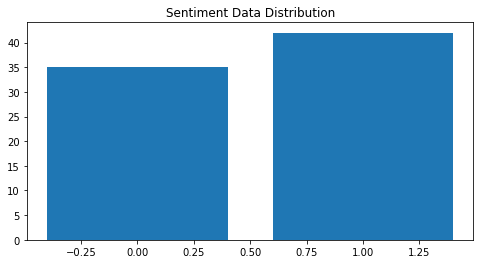

In [79]:
#Sentiment Data Distribution
val_count = data.polarity.value_counts()

plt.figure(figsize=(8,4))
plt.bar(val_count.index, val_count.values)
plt.title("Sentiment Data Distribution")

In [80]:
# check the number of positive vs. negative tagged sentences
positives = data['polarity'][data.polarity == 1 ]
negatives = data['polarity'][data.polarity == 0 ]

print('Total length of the data is:         {}'.format(data.shape[0]))
print('No. of positve tagged sentences is:  {}'.format(len(positives)))
print('No. of negative tagged sentences is: {}'.format(len(negatives)))

Total length of the data is:         77
No. of positve tagged sentences is:  42
No. of negative tagged sentences is: 35


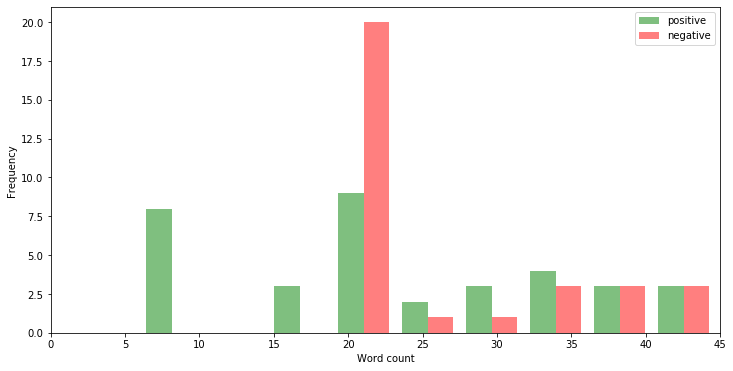

In [81]:
# get a word count per of text
def word_count(words):
    return len(words.split())

# plot word count distribution for both positive and negative 

data['word count'] = data['text'].apply(word_count)
p = data['word count'][data.polarity == 1]
n = data['word count'][data.polarity == 0]
plt.figure(figsize=(12,6))
plt.xlim(0,45)
plt.xlabel('Word count')
plt.ylabel('Frequency')
g = plt.hist([p, n], color=['g','r'], alpha=0.5, label=['positive','negative'])
plt.legend(loc='upper right')

In [82]:
#top 10 most frequent words in dataset
from collections import Counter
all_words = []
for line in list(data['text']):
    words = line.split()
    for word in words:
      if(len(word)>2):
        all_words.append(word.lower())
    
    
Counter(all_words).most_common(10)

[('the', 58),
 ('#antivaxxers', 49),
 ('and', 49),
 ('vaccination', 39),
 ('are', 31),
 ('people', 29),
 ('who', 29),
 ('#vaccination', 27),
 ('vaccinations', 23),
 ('how', 22)]

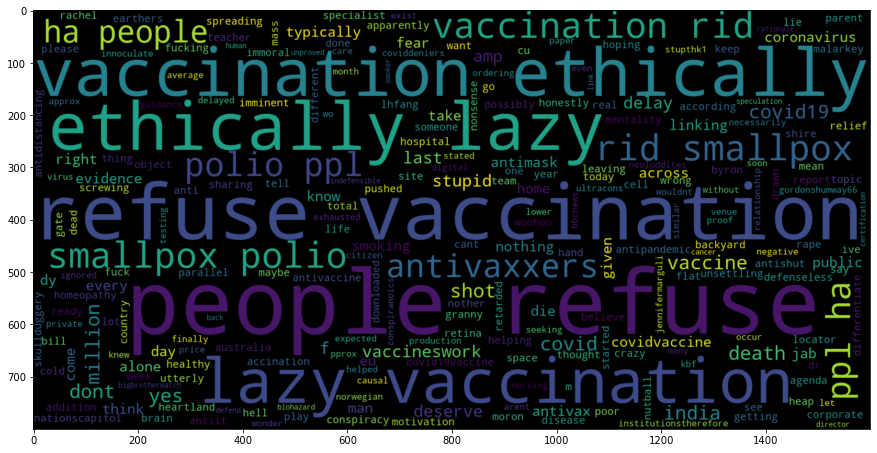

In [83]:
#Word-Cloud for Negative Tweets

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 250 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 0].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

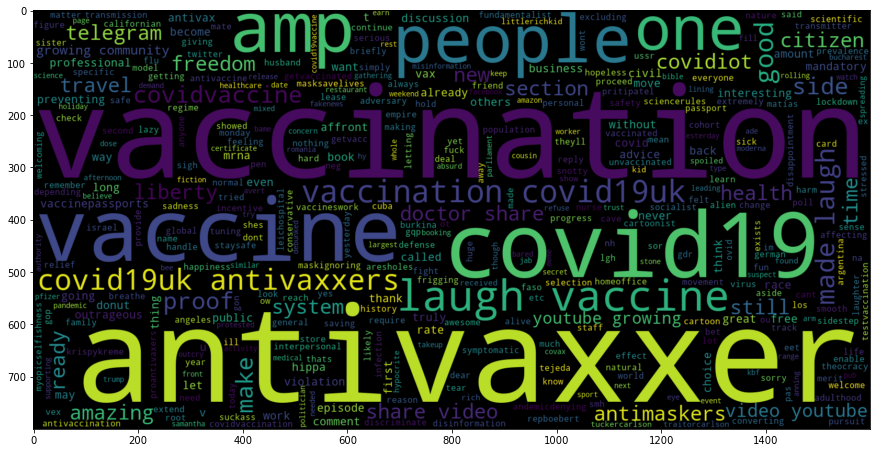

In [84]:
#Word-Cloud for positive tweets

plt.figure(figsize = (15,15)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(data[data.polarity == 1].processed_tweets))
plt.imshow(wc , interpolation = 'bilinear')

In [89]:
data["processed_tweets"][9]

'cu specialist dr rachel heap life australia antivax heartland byron shire covid19 vaccination last week antivaxxers started spreading lie imminent death report'

In [91]:
#sort by ascending vader_compound score

data.sort_values(by=['vader_compound'], inplace=True)

In [92]:
data.head()

,text,processed_tweets,vader_compound,polarity,word count
61,@lhfang This is utterly immoral\nThe motivatio...,lhfang utterly immoral motivation helping peop...,-0.8487,0,47
14,We don't have mass vaccination sites in the #n...,dont mass vaccination site nationscapitol dont...,-0.8415,0,47
115,@bbcnews stated #EU vaccination delays because...,bbcnews stated eu vaccination delay production...,-0.8287,0,36
47,Vaccination day woohoo.\n\nFuck you anti-vaxxe...,accination day woohoo fuck antivaxxers keep sh...,-0.7713,0,37
66,All this vaccination nonsense! \n\nThe Bill Ga...,vaccination nonsense bill gate conspiracy mala...,-0.7269,0,31


In [107]:
#small sample of tweets with negative vader_compound score

pd.options.display.max_rows
pd.set_option('display.max_colwidth', -1)

data.iloc[:5]

,text,processed_tweets,vader_compound,polarity,word count
61,"@lhfang This is utterly immoral\nThe motivation should be about helping people, not screwing every last $ out of them &amp; leaving poor countries out in the cold\nDon't they see it plays into the hands of crazy #antivaxxers who can't differentiate between vaccination &amp; corporate skullduggery",lhfang utterly immoral motivation helping people screwing every last amp leaving poor country cold dont see play hand crazy antivaxxers cant differentiate vaccination amp corporate skullduggery,-0.8487,0,47
14,We don't have mass vaccination sites in the #nationscapitol because - they don't want it?\n\nWhat say you @potus @vp are you ready for dead teachers right in your backyard then the parents at home maybe granny\n\nWe are are defenseless against all the nutball #antimask #antivaxxers,dont mass vaccination site nationscapitol dont want say ready dead teacher right backyard parent home maybe granny defenseless nutball antimask antivaxxers,-0.8415,0,47
115,"@bbcnews stated #EU vaccination delays because of production delays. No they aren't. The delays exist because @Europarl_EN @EU_Commission delayed ordering by months seeking lower prices, then ignored @EMA_News guidance, and many #EU citizens are #AntiVaxxers. @vonderleyen",bbcnews stated eu vaccination delay production delay arent delay exist delayed ordering month seeking lower price ignored guidance many eu citizen antivaxxers,-0.8287,0,36
47,"Vaccination day woohoo.\n\nFuck you anti-vaxxers.... \nKeep sharing your one brain cell between your retarded thoughts and the flat earthers. Total fucking morons the lot of you, here's hoping you all get it and die. \n#CovidVaccine #antivaxxers",accination day woohoo fuck antivaxxers keep sharing one brain cell retarded thought flat earthers total fucking moron lot here hoping get die covidvaccine antivaxxers,-0.7713,0,37
66,All this vaccination nonsense! \n\nThe Bill Gates conspiracy and all that malarkey! \n\nIn addition to getting the Coronavirus locator jab today I downloaded MS Teams into my retinas too. #COVID19Vaccine #antivaxxers,vaccination nonsense bill gate conspiracy malarkey addition getting coronavirus locator jab today downloaded m team retina covid19vaccine antivaxxers,-0.7269,0,31


In [106]:
#small sample of tweets with the most positive vader_compound intesity score

data.iloc[-6:]

,text,processed_tweets,vader_compound,polarity,word count
90,I'm so ready for the Israel model. Let the businesses handle it by not letting anyone in their stores without a vaccination pass. Fuck the #AntiVaxxers I'm ready to move on. Let them figure it out on their own while we get back to normal. https://t.co/djm8Av2Flu,ready israel model let business handle letting anyone store without vaccination pas fuck antivaxxers im ready move let figure get back normal,0.7814,1,46
23,"Pandemic-denying, #mask-ignoring, anti-#vaccination people are not making a 'personal choice'-- this is an interpersonal #virus and their myopic-selfishness is affecting the 'Life, Liberty and Pursuit of Happiness'; for ALL of us. \n\n#antivaxxers #vaccinepassports \n#masksavelives",andemicdenying maskignoring antivaccination people making personal choice interpersonal virus myopicselfishness affecting life liberty pursuit happiness u antivaxxers vaccinepassports masksavelives,0.7906,1,34
5,RT @ViraniPinki: Vex vax. Interesting as advice but truly great discussion in the Comments section. #vaccine #vaccination #COVID19 #GetVacc…,vex vax interesting advice truly great discussion comment section vaccine vaccination covid19 getvacc…,0.8658,1,19
12,"@krispykreme tried to provide an incentive for getting the #CovidVaccine by giving away free donuts if you showed your vaccination card. Yet, they proceed to extend the free donut deal to #antivaxxers on Mondays?!? Make it make sense. 🤦🏾‍♀️ https://t.co/EAL1uj1q49",krispykreme tried provide incentive getting covidvaccine giving away free donut showed vaccination card yet proceed extend free donut deal antivaxxers monday make make sense 🤦🏾‍♀️,0.9042,1,40
75,"You know in history, a lot of conservative regimes like the German Empire made vaccination mandatory for its citizen the same way as socialist systems like Cuba, Burkina Faso, USSR, GDR did. Your ""freedom"" means the freedom to harm other people, dear #covidiots and #antivaxxers",ou know history lot conservative regime like german empire made vaccination mandatory citizen way socialist system like cuba burkina faso ussr gdr freedom mean freedom harm people dear covidiots antivaxxers,0.9153,1,45
8,"Vex vax. Interesting as advice but truly great discussion in the Comments section. #vaccine #vaccination #COVID19 #GetVaccinated #antivax #antivaxxers #AntiVaccine @AnnalisaB \n\nMy friend is an anti-vaxxer, and she's converting my husband. What can I do? https://t.co/csBKKKHc6W",ex vax interesting advice truly great discussion comment section vaccine vaccination covid19 getvaccinated antivax antivaxxers antivaccine friend antivaxxer shes converting husband,0.9169,1,36


In [ ]:
'''
Problem: how to categorize tweets as either pro vaccination/anti vaccination
(need help here...)
->Look into topic modelling(unsupervised learning), LDAs
'''

# Looping through Requests

IDEA:

if we want to save more responses: Beyond the first 500 results that Twitter gave us or if we want to automate getting Tweets over a specific period of time.


In [ ]:
'''

#Inputs for tweets
bearer_token = auth()
headers = create_headers(bearer_token)
keyword = "xbox lang:en"
start_list =    ['2021-01-01T00:00:00.000Z',
                 '2021-02-01T00:00:00.000Z',
                 '2021-03-01T00:00:00.000Z']

end_list =      ['2021-01-31T00:00:00.000Z',
                 '2021-02-28T00:00:00.000Z',
                 '2021-03-31T00:00:00.000Z']
max_results = 500

#Total number of tweets we collected from the loop
total_tweets = 0

# Create file
csvFile = open("data.csv", "a", newline="", encoding='utf-8')
csvWriter = csv.writer(csvFile)

#Create headers for the data you want to save, in this example, we only want save these columns in our dataset
csvWriter.writerow(['author id', 'created_at', 'geo', 'id','lang', 'like_count', 'quote_count', 'reply_count','retweet_count','source','tweet'])
csvFile.close()

for i in range(0,len(start_list)):

    # Inputs
    count = 0 # Counting tweets per time period
    max_count = 100 # Max tweets per time period
    flag = True
    next_token = None
    
    # Check if flag is true
    while flag:
        # Check if max_count reached
        if count >= max_count:
            break
        print("-------------------")
        print("Token: ", next_token)
        url = create_url(keyword, start_list[i],end_list[i], max_results)
        json_response = connect_to_endpoint(url[0], headers, url[1], next_token)
        result_count = json_response['meta']['result_count']

        if 'next_token' in json_response['meta']:
            # Save the token to use for next call
            next_token = json_response['meta']['next_token']
            print("Next Token: ", next_token)
            if result_count is not None and result_count > 0 and next_token is not None:
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)                
        # If no next token exists
        else:
            if result_count is not None and result_count > 0:
                print("-------------------")
                print("Start Date: ", start_list[i])
                append_to_csv(json_response, "data.csv")
                count += result_count
                total_tweets += result_count
                print("Total # of Tweets added: ", total_tweets)
                print("-------------------")
                time.sleep(5)
            
            #Since this is the final request, turn flag to false to move to the next time period.
            flag = False
            next_token = None
        time.sleep(5)
print("Total number of results: ", total_tweets)


'''